In [202]:
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from nltk.stem import WordNetLemmatizer

# Tensorflow libraries
# Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text, sequence
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

import tensorflow_hub as hub


# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score

from gensim.models import Word2Vec # Word2Vec module
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, remove_stopwords, strip_numeric, stem_text


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-content-detection/train.csv
/kaggle/input/fake-news-content-detection/test.csv
/kaggle/input/fake-news-content-detection/sample submission.csv


## Load Dataset

In [203]:
train_data = pd.read_csv("/kaggle/input/fake-news-content-detection/train.csv")
test_data = pd.read_csv("/kaggle/input/fake-news-content-detection/test.csv")
submission_data = pd.read_csv("/kaggle/input/fake-news-content-detection/sample submission.csv")

In [204]:
# Sample data from training data
train_data.sample(3)


,Labels,Text,Text_Tag
8026,4,"Rick Santorum says Rick Perry requested 1,200 ...","congress,federal-budget"
5841,0,Studies suggest the 2017 College Football Play...,"jobs,sports"
9682,1,The debt comes up all the time in town meeting...,"debt,federal-budget"


In [205]:
# Dataset information
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Labels    10240 non-null  int64 
 1   Text      10240 non-null  object
 2   Text_Tag  10238 non-null  object
dtypes: int64(1), object(2)
memory usage: 240.1+ KB


In [206]:
train_data[train_data.duplicated(['Text'])]

,Labels,Text,Text_Tag
1014,2,On abortion,"abortion,candidates-biography"
1814,1,On support for gay marriage.,"civil-rights,families,gays-and-lesbians,marriage"
1846,1,"Obama says Iran is a 'tiny' country, 'doesn't ...",foreign-policy
2697,1,On repealing the 17th Amendment,"debates,elections,states"
2846,3,"Four balanced budgets in a row, with no new ta...","job-accomplishments,jobs,state-budget,state-fi..."
3256,1,On a cap-and-trade plan.,"cap-and-trade,climate-change,environment"
4386,1,On the Trans-Pacific Partnership.,trade
4839,2,During Sherrod Browns past decade as a D.C. po...,"economy,job-accomplishments,jobs"
4940,1,On changing the rules for filibusters on presi...,congressional-rules
6759,2,On torture.,"human-rights,terrorism"


In [207]:
train_data = train_data.drop_duplicates(['Text'])

In [208]:
train_data.sample(3)

,Labels,Text,Text_Tag
1767,4,Nobody is leaving Memphis. Thats a myth.,"census,population,taxes"
3299,2,Says black women are fastest-growing demograph...,guns
4179,5,"Ken Buck wants to outlaw abortion, even in cas...","abortion,message-machine"


In [ ]:
## word cloud for text_tag
cloud = WordCloud(width=1300, height=950).generate(" ".join(train_q.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

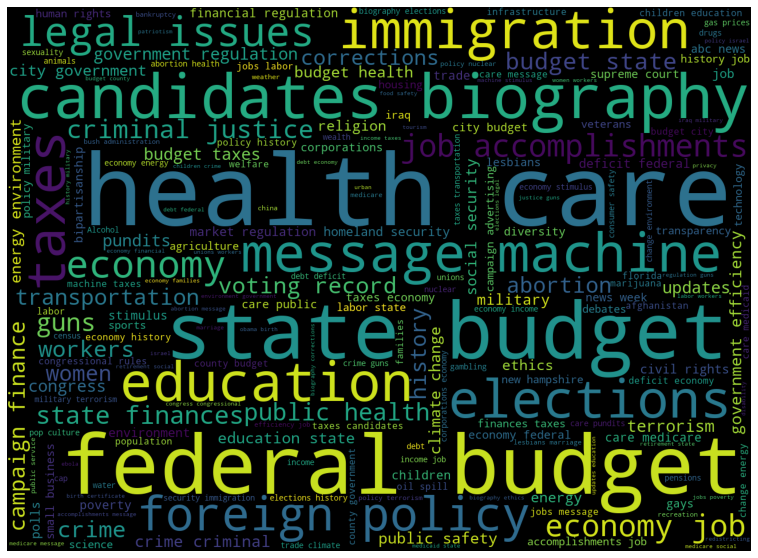

In [ ]:

from wordcloud import WordCloud
cloud = WordCloud(width=1300, height=950).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

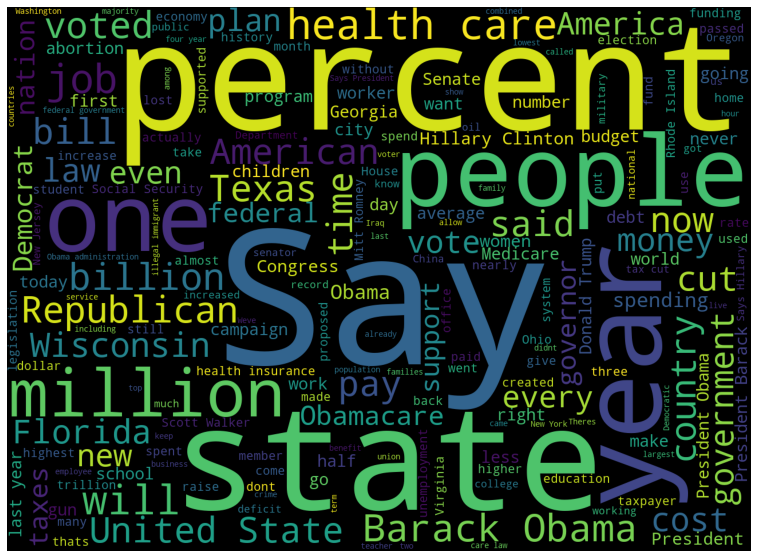

In [252]:
X = train_data['Processed']
y = train_data['Labels']

y_category = keras.utils.to_categorical(y, 6)

# Split data into Train and Holdout as 80:20 ratio
X_train, X_valid, y_train, y_valid = train_test_split(X, y_category, shuffle=True, test_size=0.33, random_state=111)

print("Train shape : {}, Holdout shape: {}".format(X_train.shape, X_valid.shape))

Train shape : (6849,), Holdout shape: (3374,)


In [253]:
def word_embedding(train, test, max_features, max_len=200):
    try:
        # Keras Tokenizer class object
        tokenizer = text.Tokenizer(num_words=max_features)
        tokenizer.fit_on_texts(train)
        
        train_data = tokenizer.texts_to_sequences(train)
        test_data = tokenizer.texts_to_sequences(test)
        
        # Get the max_len
        vocab_size = len(tokenizer.word_index) + 1
        
        # Padd the sequence based on the max-length
        x_train = sequence.pad_sequences(train_data, maxlen=max_len, padding='post')
        x_test = sequence.pad_sequences(test_data, maxlen=max_len, padding='post')
        # Return train, test and vocab size
        return tokenizer, x_train, x_test, vocab_size
    except ValueError as ve:
        raise(ValueError("Error in word embedding {}".format(ve)))


In [308]:
max_features = 5000
max_len = 128
output_dim = len(np.unique(y))

# Test data
X_test = test_data['Processed']

tokenizer, x_pad_train, x_pad_valid, vocab_size = word_embedding(X_train, X_valid, max_features)

In [309]:
# Test data
X_test = test_data['Processed']

tokenizer.fit_on_sequences(X_test)

X_test_seq = tokenizer.texts_to_sequences(X_test)
x_pad_test = sequence.pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [310]:
def compute_classweights(target):
    """
    Computes the weights of the target values based on the samples
    :param target: Y-target variable
    :return: dictionary object
    """
    # compute class weights
    class_weights = class_weight.compute_class_weight('balanced',
                                                     np.unique(target),
                                                     target)
    
    # make the class weight list into dictionary
    weights = {}
    
    # enumerate the list
    for index, weight in enumerate(class_weights):
        weights[index] = weight
        
    return weights

# Get the class weights for the target variable
weights = compute_classweights(y)

In [311]:
weights

{0: 1.0307521677757612,
 1: 0.8574903539674551,
 2: 0.8078868342026236,
 3: 0.868859425463199,
 4: 2.0307906237584428,
 5: 1.017821585025886}

In [312]:
X_train.sample(3)

3960    taxes new funding state sent floridians billio...
6085    tens texas voters rick perrys wendy defeat law...
6655    voted baldwin candidate extreme increase budge...
Name: Processed, dtype: object

In [313]:

rnn_model = Sequential([
keras.layers.Embedding(vocab_size,128,
                              input_length=max_len),
keras.layers.BatchNormalization(),
keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.002)),
keras.layers.GlobalMaxPool1D(), # Remove flatten layer
keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.002)),
keras.layers.Dropout(0.3),
keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.002)),
keras.layers.Dropout(0.3),
keras.layers.Dense(output_dim, activation='softmax')

return rnn_model

In [314]:
rnn_model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 128, 128)          1515520   
_________________________________________________________________
batch_normalization_26 (Batc (None, 128, 128)          512       
_________________________________________________________________
dense_99 (Dense)             (None, 128, 128)          16512     
_________________________________________________________________
global_max_pooling1d_24 (Glo (None, 128)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_51 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 32)              

In [315]:
# Compile the model
rnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
                  loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
                  metrics=[tf.metrics.AUC()])

In [316]:
history = rnn_model.fit(x_pad_train, 
                        y_train,
                        batch_size=512,
                        epochs=20,
                        verbose=1,
                        validation_data=(x_pad_valid, y_valid),
                       class_weight=weights)

Epoch 1/20
14/14 [==============================] - 1s 72ms/step - loss: 2.2825 - auc_29: 0.4780 - val_loss: 2.2350 - val_auc_29: 0.4785
Epoch 2/20
14/14 [==============================] - 1s 51ms/step - loss: 2.1977 - auc_29: 0.5346 - val_loss: 2.1701 - val_auc_29: 0.5168
Epoch 3/20
14/14 [==============================] - 1s 53ms/step - loss: 2.1246 - auc_29: 0.5849 - val_loss: 2.1146 - val_auc_29: 0.5480
Epoch 4/20
14/14 [==============================] - 1s 59ms/step - loss: 2.0554 - auc_29: 0.6176 - val_loss: 2.0714 - val_auc_29: 0.5562
Epoch 5/20
14/14 [==============================] - 1s 59ms/step - loss: 1.9910 - auc_29: 0.6624 - val_loss: 2.0377 - val_auc_29: 0.5565
Epoch 6/20
14/14 [==============================] - 1s 51ms/step - loss: 1.9194 - auc_29: 0.7001 - val_loss: 2.0130 - val_auc_29: 0.5636
Epoch 7/20
14/14 [==============================] - 1s 52ms/step - loss: 1.8560 - auc_29: 0.7401 - val_loss: 1.9953 - val_auc_29: 0.5627
Epoch 8/20
14/14 [=======================

In [317]:
results = rnn_model.evaluate(x_pad_valid, y_valid)

106/106 [==============================] - 0s 4ms/step - loss: 1.9256 - auc_29: 0.5748


In [318]:
y_preds = rnn_model.predict_proba(x_pad_test, batch_size=256)

In [319]:
y_preds[:,0]

array([0.10799249, 0.10470885, 0.20419715, ..., 0.11288042, 0.07156285,
       0.0953638 ], dtype=float32)

In [320]:
final_df = pd.DataFrame({'0': y_preds[:,0],
                        '1': y_preds[:,1],
                        '2': y_preds[:,2],
                        '3': y_preds[:,3],
                        '4': y_preds[:,4],
                        '5': y_preds[:,5]}, index=test_data.index)

In [321]:
final_df

,0,1,2,3,4,5
0,0.107992,0.101322,0.150519,0.378211,0.134148,0.127807
1,0.104709,0.158395,0.332498,0.163373,0.189925,0.051100
2,0.204197,0.133102,0.249838,0.167857,0.143589,0.101418
3,0.167783,0.325967,0.100499,0.088033,0.130143,0.187575
4,0.174848,0.282983,0.110808,0.102282,0.210029,0.119051
...,...,...,...,...,...,...
1262,0.125772,0.097854,0.083867,0.338114,0.165196,0.189197
1263,0.142004,0.104889,0.095647,0.265502,0.085052,0.306905
1264,0.112880,0.168333,0.251629,0.280145,0.070717,0.116296
1265,0.071563,0.260155,0.113663,0.235579,0.170863,0.148177


In [322]:
final_df.to_csv("fake_news_ann_08.csv", index=False)